1. Token level perplexity in training set |

In [1]:
# load gpt2 model to test first
from model import GPT 
import tiktoken 

enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)
gpt2 = GPT.from_pretrained('gpt2')

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


In [2]:
# enc._special_tokens
text = "DeepSeek's architectural innovations (MoE, MLA, MTP, and FP8 Quantization) focus on optimizing large-scale training and deployment and serving efficiency. Not single-user or local runtime performance, e.g., MoE requires the same memory footprint as the Dense model despite using fewer parameters per inference, MTP's parallel token generation mainly benefits high-throughput scenarios."

import torch 
token_ids = torch.tensor(encode(text)).view(1, -1)
input_ids, target_ids = token_ids[:, :-1], token_ids[:, 1:]
logits, token_loss = gpt2(input_ids, targets=target_ids, reduction='none') # loss is provided as an 'average' loss per token --- I want singular loss per token 

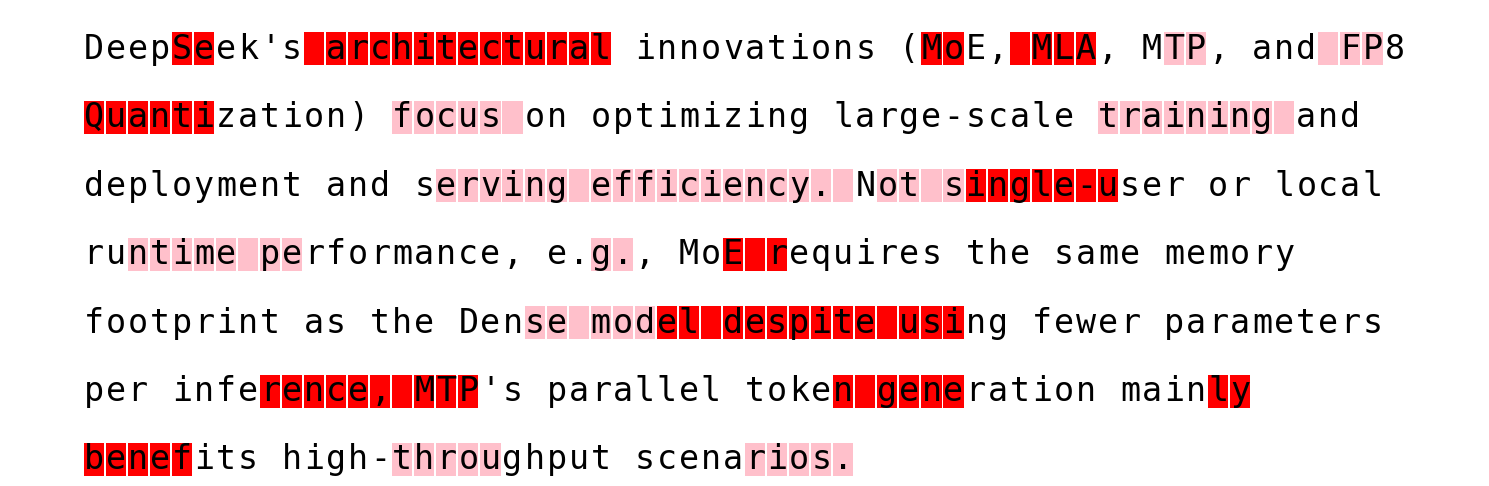

In [3]:
from src.vis import display_colored_text
from src.utils import shift_token_loss, map_token_to_char_perplexity, get_naive_char_color

token_perplexity = shift_token_loss(token_loss)
char_perplexity = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode)
char_colors = get_naive_char_color(char_perplexity)
display_colored_text(text, char_colors)

In [3]:
# Quantile threshold for logit loss values
quantile_threshold = 0.80
loss_threshold = torch.quantile(token_loss, 0.80)

# IDEA 1. Just to train a different tokenization base on the CharLM performance, and see if it improve performance
# ... Continuous morphing of tokenization scheme during training ...
# 'Merge tokens with similar embeddings'
# 'Spike in perplexity --> breaking token (if it's continuous)'
# 'Continuous Drop in perplexity --> merge tokens (if there are multiple tokens)'

# (a). Embedding similarity 
def detect_embedding_similarity(token_loss, quantile_threshold=0.80): 
    raise NotImplementedError


# (b). Spike in perplexity 
# 'spike token': a token which has jump in perplexity above quantile threshold 
def detect_spike_token(token_loss, quantile_threshold=0.80): 
    """ 
    Spike token cross perplexity threshold, and shows a sudden increase in perplexity
    """
    loss_threshold = torch.quantile(token_loss, quantile_threshold)
    spike_tokens = []
    for i in range(len(token_loss)):
        last_token_loss = token_loss[max(i-1, 0)]
        if token_loss[i] > loss_threshold and token_loss[i] > last_token_loss: 
            spike_tokens.append(i)
    return spike_tokens

# (c). Natural token: detect continuous drop in perplexity with in-group low perplexity below quantile threshold 
def detect_natural_group(token_loss, quantile_threshold=0.7): 
    """ 
    natural_group: 1. Decreasing in token perplexity | 2. From second token onwards perplexity should be lower than threshold 
    """
    natural_group = []
    for i in range(len(token_loss)):
        if i == 0: 
            continue 
        if token_loss[i] < quantile_threshold and token_loss[i] < token_loss[i-1]:
            natural_group.append(i)
    return natural_group

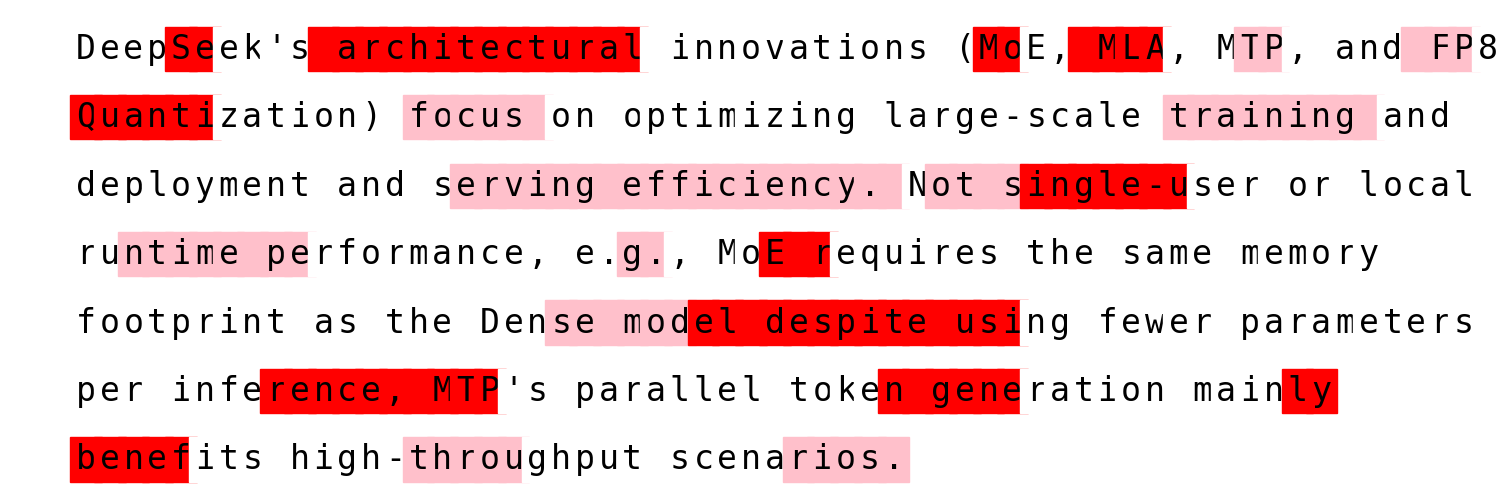

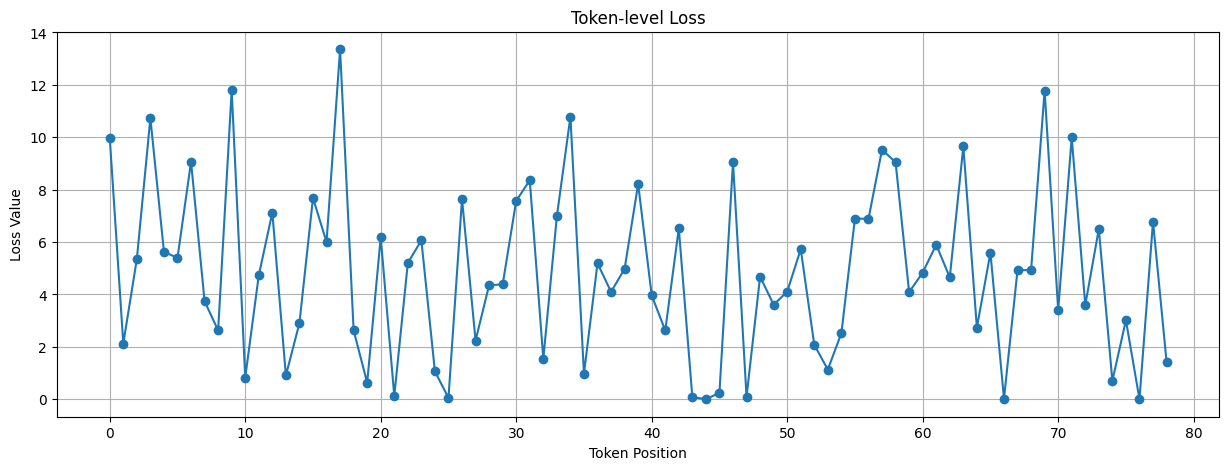


Tokens with highest loss:
1. Loss: 13.36, Token: ' Quant'
2. Loss: 11.80, Token: ' MLA'
3. Loss: 11.78, Token: ' token'
4. Loss: 10.78, Token: ' single'
5. Loss: 10.73, Token: ' architectural'


In [9]:

# do a plot of the token-level loss
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(token_loss.detach().numpy(), marker='o')
plt.title('Token-level Loss')
plt.xlabel('Token Position') 
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

# Print tokens with highest loss
top_k = 5
top_losses = torch.topk(token_loss, k=top_k)
print("\nTokens with highest loss:")
for i, (loss_val, idx) in enumerate(zip(top_losses.values, top_losses.indices)):
    token = decode([target_ids[0, idx]])
    print(f"{i+1}. Loss: {loss_val:.2f}, Token: '{token}'")


In [6]:
# logits.shape | Apple's approch to optimize training memory -- can we reduce the logit shape? 
token_loss.shape

torch.Size([7])

In [14]:
tokens

['Se',
 'ek',
 "'s",
 ' architectural',
 ' innovations',
 ' (',
 'Mo',
 'E',
 ',',
 ' MLA',
 ',',
 ' M',
 'TP',
 ',',
 ' and',
 ' FP',
 '8',
 ' Quant',
 'ization',
 ')',
 ' focus',
 ' on',
 ' optimizing',
 ' large',
 '-',
 'scale',
 ' training',
 ' and',
 ' deployment',
 ' and',
 ' serving',
 ' efficiency',
 '.',
 ' Not',
 ' single',
 '-',
 'user',
 ' or',
 ' local',
 ' runtime',
 ' performance',
 ',',
 ' e',
 '.',
 'g',
 '.,',
 ' Mo',
 'E',
 ' requires',
 ' the',
 ' same',
 ' memory',
 ' footprint',
 ' as',
 ' the',
 ' D',
 'ense',
 ' model',
 ' despite',
 ' using',
 ' fewer',
 ' parameters',
 ' per',
 ' inference',
 ',',
 ' M',
 'TP',
 "'s",
 ' parallel',
 ' token',
 ' generation',
 ' mainly',
 ' benefits',
 ' high',
 '-',
 'through',
 'put',
 ' scenarios',
 '.']